Found 16252 validated image filenames belonging to 4 classes.
Found 1242 validated image filenames belonging to 4 classes.
Found 1242 validated image filenames belonging to 4 classes.
20/20 [==============================] - 4s 176ms/step
训练集准确率: 25.58%
验证集准确率: 29.87%
测试集准确率: 95.17%
软投票集成模型分类报告:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       370
           1       0.98      0.99      0.98       507
           2       1.00      0.66      0.79       137
           3       0.86      0.99      0.92       228

    accuracy                           0.95      1242
   macro avg       0.95      0.91      0.92      1242
weighted avg       0.96      0.95      0.95      1242



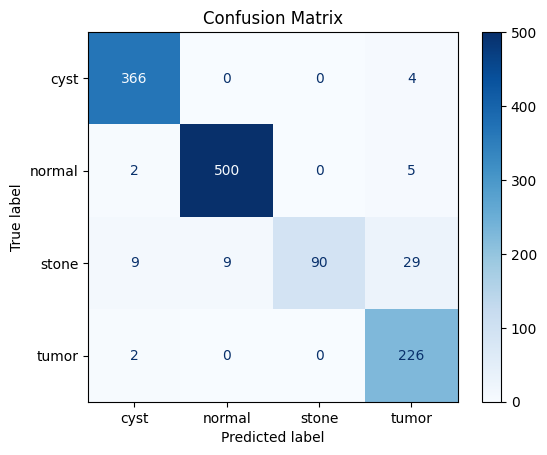

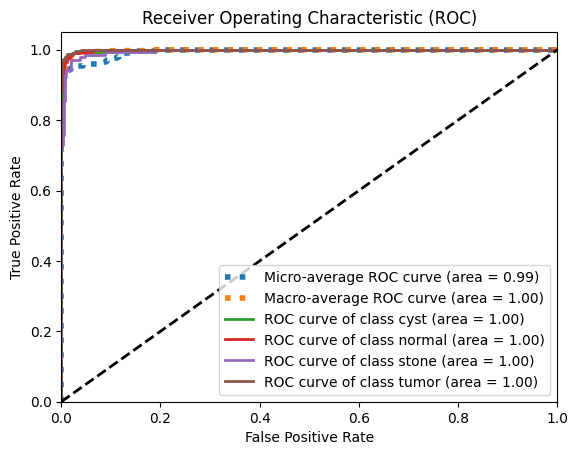

In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
from sklearn.preprocessing import label_binarize

# 数据集路径
dataset_dir = r'C:\Users\zhou\Desktop\dataset'
train_dir = os.path.join(dataset_dir, 'train(augmented)')
val_dir = os.path.join(dataset_dir, 'val')
test_dir = os.path.join(dataset_dir, 'test')

# 标签文件路径
train_labels_path = r'C:\Users\zhou\Desktop\dataset\train.csv'
val_labels_path = r'C:\Users\zhou\Desktop\dataset\val.csv'
test_labels_path = r'C:\Users\zhou\Desktop\dataset\test.csv'

# 加载标签并更新路径
train_df = pd.read_csv(train_labels_path)
train_df['path'] = train_df['path'].apply(lambda x: os.path.join(train_dir, x))

val_df = pd.read_csv(val_labels_path)
val_df['path'] = val_df['path'].apply(lambda x: os.path.join(val_dir, x))

test_df = pd.read_csv(test_labels_path)
test_df['path'] = test_df['path'].apply(lambda x: os.path.join(test_dir, x))

# 定义超参数
batch_size = 64  # 批次大小，减小显存占用
epochs = 5  # 训练轮数
img_size = (224, 224)  # 图像尺寸

# 数据生成器（用于图像数据增强和预处理）
train_datagen = ImageDataGenerator(rescale=1./255)  # 训练集数据归一化
val_datagen = ImageDataGenerator(rescale=1./255)  # 验证集数据归一化
test_datagen = ImageDataGenerator(rescale=1./255)  # 测试集数据归一化

# 生成训练集、验证集和测试集的图像生成器
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='path',  # 图像路径
    y_col='label',  # 标签
    target_size=img_size,  # 图像尺寸调整
    color_mode='rgb',  # 彩色图像
    class_mode='categorical',  # 分类任务
    batch_size=batch_size  # 每批次大小
)

val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='path',  # 图像路径
    y_col='label',  # 标签
    target_size=img_size,  # 图像尺寸调整
    color_mode='rgb',  # 彩色图像
    class_mode='categorical',  # 分类任务
    batch_size=batch_size  # 每批次大小
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='path',  # 图像路径
    y_col='label',  # 标签
    target_size=img_size,  # 图像尺寸调整
    color_mode='rgb',  # 彩色图像
    class_mode='categorical',  # 分类任务
    batch_size=batch_size,  # 每批次大小
    shuffle=False  # 不打乱顺序
)

# 加载预训练模型
googlenet_model = tf.keras.models.load_model(r"C:\Users\zhou\Desktop\dataset\Model\googlenet.h5")  # 加载GoogLeNet模型
shufflenet_model = tf.keras.models.load_model(r"C:\Users\zhou\Desktop\dataset\Model\shufflenet.h5")  # 加载ShuffleNet模型
alexnet_model = tf.keras.models.load_model(r"C:\Users\zhou\Desktop\dataset\Model\alexnet.h5")  # 加载AlexNet模型

# 定义模型列表
models = [googlenet_model, shufflenet_model, alexnet_model]

# 获取基模型的预测结果，用于软投票
def get_base_model_predictions(models, generator):
    base_predictions = []  # 存储所有基模型的预测结果
    for model in models:
        # 使用predict_generator按批次加载数据，避免显存不足
        model_preds = model.predict(generator, batch_size=batch_size)
        base_predictions.append(model_preds)  # 将每个模型的预测结果添加到列表中
        # 清理模型以释放显存
        tf.keras.backend.clear_session()
    
    # 将所有模型的预测结果按列进行堆叠
    stacked_predictions = np.array(base_predictions)  # (n_models, n_samples, n_classes)
    return stacked_predictions

# 获取真实标签
y_true = test_generator.classes

# 获取训练集、验证集和测试集的基模型预测结果
X_train = get_base_model_predictions(models, train_generator)
X_val = get_base_model_predictions(models, val_generator)
X_test = get_base_model_predictions(models, test_generator)

# 计算软投票：对每个样本，计算所有模型预测概率的平均值
def soft_voting(predictions):
    return np.argmax(np.mean(predictions, axis=0), axis=1)

# 计算训练集和测试集的软投票预测结果
train_preds = soft_voting(X_train)
val_preds = soft_voting(X_val)
test_preds = soft_voting(X_test)

# 评估软投票模型的性能
train_accuracy = accuracy_score(train_generator.classes, train_preds)
val_accuracy = accuracy_score(val_generator.classes, val_preds)
test_accuracy = accuracy_score(y_true, test_preds)

# 输出结果
print(f'训练集准确率: {train_accuracy * 100:.2f}%')
print(f'验证集准确率: {val_accuracy * 100:.2f}%')
print(f'测试集准确率: {test_accuracy * 100:.2f}%')

# 打印测试集的分类报告
print("软投票集成模型分类报告:")
print(classification_report(y_true, test_preds))

# 绘制混淆矩阵
def plot_confusion_matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)  # 计算混淆矩阵
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap=plt.cm.Blues, values_format='d')  # 可视化混淆矩阵
    plt.title("Confusion Matrix")
    plt.show()

# 绘制 AUC-ROC 曲线
def plot_roc_curve(y_true, y_prob, class_names):
    y_true_bin = label_binarize(y_true, classes=range(len(class_names)))  # 标签二值化
    fpr = {}
    tpr = {}
    roc_auc = {}
    
    # 为每个类别计算 ROC 曲线和 AUC
    for i in range(len(class_names)):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_prob[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    # 计算微观和宏观平均 ROC 曲线和 AUC
    fpr["micro"], tpr["micro"], _ = roc_curve(y_true_bin.ravel(), y_prob.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(len(class_names))]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(len(class_names)):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
    mean_tpr /= len(class_names)
    
    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
    
    # 绘制所有类别的 ROC 曲线
    plt.figure()
    plt.plot(fpr["micro"], tpr["micro"], label=f"Micro-average ROC curve (area = {roc_auc['micro']:.2f})", linestyle=':', linewidth=4)
    plt.plot(fpr["macro"], tpr["macro"], label=f"Macro-average ROC curve (area = {roc_auc['macro']:.2f})", linestyle=':', linewidth=4)
    
    for i in range(len(class_names)):
        plt.plot(fpr[i], tpr[i], lw=2, label=f"ROC curve of class {class_names[i]} (area = {roc_auc[i]:.2f})")
    
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.show()

# 计算预测概率的平均值用于绘制 AUC-ROC 曲线
y_prob = np.mean(X_test, axis=0)  # 计算所有模型的预测概率的平均值
class_names = list(test_generator.class_indices.keys())  # 获取类别名称

# 绘制混淆矩阵
plot_confusion_matrix(y_true, test_preds, class_names)

# 绘制 AUC-ROC 曲线
plot_roc_curve(y_true, y_prob, class_names)